### Integrating LLC and Refined LLC Evaluation into Reinforcement Learning

This notebook demonstrates the integration of Local Learning Coefficient (LLC) and refined, layer-wise LLC evaluation into an existing Reinforcement Learning (RL) codebase. 

**Objective:** Augment a standard RL training loop with advanced complexity metrics to analyze the model's learning dynamics without disrupting the core training process.

**Methodology:**
1.  **Analyze Original Code:** Start with a baseline RL implementation featuring a Transformer model.
2.  **Integrate LLC Library:** Port the necessary classes for LLC estimation (`LLCEstimator`, `SGLDSampler`, etc.).
3.  **Modify Training Loop:** Adapt the main RL training loop to collect data and trigger LLC analysis at the end of each episode.
4.  **Visualize Results:** Add new plots to visualize the evolution of overall and layer-wise LLC alongside standard RL metrics like rewards and loss.

In [ ]:
# Core imports from both original files
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
import os
from collections import defaultdict
import pickle
import networkx as nx
from sklearn.cluster import KMeans
import copy
import time
import logging
from torch.utils.data import DataLoader, TensorDataset

# Suppress unnecessary warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Configure notebook for inline plotting
%matplotlib inline

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

episodes = 1000

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Using device: cpu


### Original RL Code Structure

These are the original classes from `Python Code 1`, defining the model architecture, environment, and basic configuration.

In [2]:
class SimpleTransformer(nn.Module):
    """Transformer model for RL tasks with reasoning capabilities"""
    
    def __init__(self, vocab_size=1000, d_model=128, nhead=4, num_layers=24, 
                 dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1000, d_model) * 0.1)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        
        # For reasoning graph extraction
        self.reasoning_steps = []
        
    def forward(self, x, return_hidden=False):
        seq_len = x.size(1)
        # Token + positional embeddings
        x = self.embedding(x) + self.pos_encoding[:seq_len]
        
        # Transformer layers
        hidden_states = self.transformer(x)
        
        # Final layer norm
        x = self.ln_f(hidden_states)
        
        # Language modeling head
        logits = self.lm_head(x)
        
        if return_hidden:
            return logits, hidden_states
        return logits
    
    def extract_reasoning_steps(self, x):
        """Extract intermediate reasoning steps for graph analysis"""
        with torch.no_grad():
            _, hidden_states = self.forward(x, return_hidden=True)
            # Store reasoning steps for later analysis
            self.reasoning_steps.append(hidden_states.cpu().numpy())
        return hidden_states

@dataclass
class RLConfig:
    """Configuration for RL training"""
    num_episodes: int = 100
    max_steps_per_episode: int = 50
    learning_rate: float = 1e-4
    batch_size: int = 32
    gamma: float = 0.99
    epsilon: float = 0.1
    epsilon_decay: float = 0.995
    min_epsilon: float = 0.01

class SimpleRLEnvironment:
    """Simple RL environment for reasoning tasks"""
    
    def __init__(self, vocab_size=1000, seq_length=32):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.max_steps = 20
        self.reset()
        
    def reset(self):
        """Reset environment to initial state"""
        self.current_state = torch.randint(1, self.vocab_size, (1, self.seq_length))
        self.steps_taken = 0
        return self.current_state
    
    def step(self, action):
        """Take action and return next state, reward, done"""
        self.steps_taken += 1
        
        # Simple reward function based on action coherence
        reward = self._calculate_reward(action)
        
        # Update state
        self.current_state = torch.cat([self.current_state[:, 1:], action.unsqueeze(1)], dim=1)
        
        # Episode ends after max steps
        done = self.steps_taken >= self.max_steps
        
        return self.current_state, reward, done
    
    def _calculate_reward(self, action):
        """Calculate reward based on reasoning coherence"""
        # Simple coherence metric
        if action.item() < self.vocab_size // 2:
            return 1.0  # Positive reward for coherent actions
        else:
            return -0.1  # Small negative reward

### Step 1: Add LLC-Related Classes and Configurations

Here we add the classes from `Python Code 2` required for LLC and refined LLC calculation. This includes the configuration, samplers, estimators, and the main tracker.

In [3]:
@dataclass
class LLCConfig:
    """Configuration for LLC Estimation"""
    temperature: float = 0.1
    sgld_steps: int = 200 # Reduced for faster notebook execution
    sgld_lr: float = 1e-6
    burn_in_ratio: float = 0.8
    batch_size: int = 16 # Batch size for the temporary dataloader
    n_chains: int = 4
    gradient_clip_norm: float = 1.0
    hessian_regularization: float = 1e-5

class SGLDSampler:
    """Stochastic Gradient Langevin Dynamics sampler for LLC estimation."""
    def __init__(self, model: nn.Module, config: LLCConfig):
        self.model = model
        self.config = config
        self.device = next(model.parameters()).device
        
    def sample(self, dataloader: DataLoader, loss_fn: Callable, center_params: Dict[str, torch.Tensor]) -> List[Dict[str, torch.Tensor]]:
        samples = []
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in center_params:
                    param.copy_(center_params[name])
        
        data_iter = iter(dataloader)
        for step in range(self.config.sgld_steps):
            try:
                inputs, targets = next(data_iter)
            except StopIteration:
                data_iter = iter(dataloader)
                inputs, targets = next(data_iter)
            
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            self.model.zero_grad()
            logits = self.model(inputs)
            loss = loss_fn(logits, targets)
            
            prior_loss = 0.0
            for name, param in self.model.named_parameters():
                if name in center_params and param.requires_grad:
                    prior_loss += 0.5 * self.config.temperature * torch.sum((param - center_params[name])**2)
            
            total_loss = loss + prior_loss
            total_loss.backward()
            
            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param.add_(param.grad, alpha=-self.config.sgld_lr)
                        noise_std = np.sqrt(2 * self.config.sgld_lr / self.config.temperature)
                        noise = torch.randn_like(param) * noise_std
                        param.add_(noise)
            
            if step >= int(self.config.sgld_steps * self.config.burn_in_ratio):
                samples.append({name: p.clone().detach() for name, p in self.model.named_parameters()})
        return samples

class LLCEstimator:
    """Local Learning Coefficient estimator."""
    def __init__(self, model: nn.Module, config: LLCConfig):
        self.model = model
        self.config = config
        self.device = next(model.parameters()).device
        
    def estimate_llc(self, dataloader: DataLoader, loss_fn: Callable, center_params: Optional[Dict[str, torch.Tensor]] = None) -> Dict[str, float]:
        if center_params is None:
            center_params = {name: param.clone().detach() for name, param in self.model.named_parameters()}
        
        sampler = SGLDSampler(self.model, self.config)
        samples = sampler.sample(dataloader, loss_fn, center_params)
        
        if not samples: return {"llc_mean": 0.0, "llc_std": 0.0}
        
        loss_center = self._compute_loss(dataloader, loss_fn, center_params)
        loss_values = [self._compute_loss(dataloader, loss_fn, s).item() for s in samples]
        
        loss_mean = np.mean(loss_values)
        loss_std = np.std(loss_values)
        
        n_data = len(dataloader.dataset)
        if n_data <= 1: return {"llc_mean": 0.0, "llc_std": 0.0}
        
        llc_estimate = (loss_mean - loss_center.item()) / np.log(n_data)
        llc_std = (loss_std / np.sqrt(len(loss_values))) / np.log(n_data)
        
        return {"llc_mean": llc_estimate, "llc_std": llc_std}
    
    def _compute_loss(self, dataloader: DataLoader, loss_fn: Callable, params: Dict[str, torch.Tensor]) -> torch.Tensor:
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in params: param.copy_(params[name])
        
        self.model.eval()
        total_loss, n_batches = 0.0, 0
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                logits = self.model(inputs)
                loss = loss_fn(logits, targets)
                total_loss += loss.item()
                n_batches += 1
        self.model.train()
        return torch.tensor(total_loss / n_batches if n_batches > 0 else 0.0)

class LayerWiseAnalyzer:
    """Analyzer for identifying and categorizing model layers for refined LLC analysis."""
    def __init__(self, model: nn.Module):
        self.model = model
        self.layer_groups = self._identify_layers()
    
    def _identify_layers(self) -> Dict[str, List[str]]:
        layer_groups = defaultdict(list)
        for name, param in self.model.named_parameters():
            if "embedding" in name or "pos_encoding" in name:
                layer_groups["input_layer"].append(name)
            elif "lm_head" in name:
                layer_groups["output_layer"].append(name)
            elif "transformer.encoder.layers" in name or "transformer.layers" in name:
                parts = name.split('.')
                layer_num = next((p for p in parts if p.isdigit()), None)
                if layer_num:
                    layer_groups[f"hidden_layer_{layer_num}"].append(name)
                else:
                    layer_groups["hidden_layers_misc"].append(name)
            else:
                layer_groups["other_layers"].append(name)
        return {k: v for k, v in layer_groups.items() if v}

class ComponentSGLDSampler(SGLDSampler):
    """SGLD sampler that only perturbs specific component parameters."""
    def __init__(self, model: nn.Module, config: LLCConfig, component_params: Dict[str, torch.Tensor]):
        super().__init__(model, config)
        self.component_param_names = set(component_params.keys())

    def sample(self, dataloader: DataLoader, loss_fn: Callable, center_params: Dict[str, torch.Tensor]) -> List[Dict[str, torch.Tensor]]:
        # The sample method is modified to only update component_param_names
        samples = []
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in center_params:
                    param.copy_(center_params[name])
        
        data_iter = iter(dataloader)
        for step in range(self.config.sgld_steps):
            try:
                inputs, targets = next(data_iter)
            except StopIteration:
                data_iter = iter(dataloader)
                inputs, targets = next(data_iter)
            
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            self.model.zero_grad()
            logits = self.model(inputs)
            loss = loss_fn(logits, targets)
            
            prior_loss = 0.0
            for name, param in self.model.named_parameters():
                if name in self.component_param_names and param.requires_grad:
                    prior_loss += 0.5 * self.config.temperature * torch.sum((param - center_params[name])**2)
            
            total_loss = loss + prior_loss
            total_loss.backward()
            
            with torch.no_grad():
                for name, param in self.model.named_parameters():
                    if name in self.component_param_names and param.grad is not None:
                        param.add_(param.grad, alpha=-self.config.sgld_lr)
                        noise_std = np.sqrt(2 * self.config.sgld_lr / self.config.temperature)
                        noise = torch.randn_like(param) * noise_std
                        param.add_(noise)
            
            if step >= int(self.config.sgld_steps * self.config.burn_in_ratio):
                samples.append({name: p.clone().detach() for name, p in self.model.named_parameters()})
        return samples

class LayerWiseRefinedLLCEstimator(LLCEstimator):
    """Enhanced refined LLC estimator that operates on individual layers."""
    def __init__(self, model: nn.Module, config: LLCConfig):
        super().__init__(model, config)
        self.layer_analyzer = LayerWiseAnalyzer(model)

    def estimate_layer_wise_llc(self, dataloader: DataLoader, loss_fn: Callable, center_params: Optional[Dict[str, torch.Tensor]] = None) -> Dict[str, Dict[str, float]]:
        if center_params is None:
            center_params = {name: param.clone().detach() for name, param in self.model.named_parameters()}
        
        results = {}
        loss_center = self._compute_loss(dataloader, loss_fn, center_params)

        for layer_name, param_names in self.layer_analyzer.layer_groups.items():
            layer_params = {name: center_params[name] for name in param_names if name in center_params}
            if not layer_params: continue
            
            sampler = ComponentSGLDSampler(self.model, self.config, layer_params)
            samples = sampler.sample(dataloader, loss_fn, center_params)
            
            if not samples: continue

            loss_values = [self._compute_loss(dataloader, loss_fn, s).item() for s in samples]
            loss_mean = np.mean(loss_values)
            loss_std = np.std(loss_values)
            
            n_data = len(dataloader.dataset)
            if n_data <= 1: continue

            llc_mean = (loss_mean - loss_center.item()) / np.log(n_data)
            llc_std = (loss_std / np.sqrt(len(loss_values))) / np.log(n_data)
            
            results[layer_name] = {"llc_mean": llc_mean, "llc_std": llc_std}
        
        return results

class EnhancedRLLLCTracker:
    """Enhanced tracker with layer-wise refined LLC analysis for RL."""
    def __init__(self, model: nn.Module, config: LLCConfig):
        self.model = model
        self.config = config
        self.llc_estimator = LLCEstimator(model, config)
        self.layer_wise_estimator = LayerWiseRefinedLLCEstimator(model, config)
        self.history = []
        
    def track_episode(self, episode: int, dataloader: DataLoader, loss_fn: Callable, reward: float, track_layers: bool = True):
        logger.info(f"Episode {episode}: Computing LLC analysis...")
        center_params = {name: param.clone().detach() for name, param in self.model.named_parameters() if param.requires_grad}
        
        overall_llc = self.llc_estimator.estimate_llc(dataloader, loss_fn, center_params)
        
        results = {
            "episode": episode,
            "reward": reward,
            "overall_llc": overall_llc
        }
        
        if track_layers:
            layer_wise_llc = self.layer_wise_estimator.estimate_layer_wise_llc(dataloader, loss_fn, center_params)
            results["layer_wise_llc"] = layer_wise_llc
        
        self.history.append(results)
        logger.info(f"Episode {episode}: Overall LLC = {overall_llc['llc_mean']:.4f}")
        return results

### Step 2: Modify the RL Training Loop

The `RLTrainer` class is modified to incorporate the `EnhancedRLLLCTracker`. At the end of each episode, it collects the states and actions from the trajectory, creates a temporary `DataLoader`, and calls the tracker to perform LLC analysis.

In [4]:
class RLTrainer:
    """RL trainer with integrated LLC logging."""
    
    def __init__(self, model: nn.Module, environment: SimpleRLEnvironment, config: RLConfig, llc_config: LLCConfig):
        self.model = model.to(device)
        self.env = environment
        self.config = config
        self.llc_config = llc_config
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        
        # Initialize LLC tracker
        self.llc_tracker = EnhancedRLLLCTracker(self.model, self.llc_config)
        
        # Unified logging dictionary
        self.training_history = {
            'episode_rewards': [],
            'episode_lengths': [],
            'losses': [],
            'llc_history': [],
            'reasoning_graphs': []
        }
        
    def train(self):
        """Main training loop with post-episode LLC evaluation."""
        print("Starting RL Training with LLC Evaluation...")
        
        for episode in range(self.config.num_episodes):
            state = self.env.reset().to(device)
            episode_reward = 0
            episode_losses = []
            
            # Collect data for LLC analysis
            episode_states = []
            episode_actions = []
            reasoning_trajectory = []
            
            done = False
            pbar = tqdm(total=self.env.max_steps, desc=f"Episode {episode+1}/{self.config.num_episodes}", leave=False)
            while not done:
                # Forward pass
                logits = self.model(state)

                # Extract reasoning step
                hidden = self.model.extract_reasoning_steps(state)
                reasoning_trajectory.append(hidden.mean(dim=(0, 1)).cpu().numpy())
                
                # Action selection (epsilon-greedy)
                if np.random.random() < self.config.epsilon:
                    action = torch.randint(0, self.model.lm_head.out_features, (1,)).to(device)
                else:
                    action = torch.argmax(logits[0, -1]).unsqueeze(0)
                
                # Store data for LLC before environment step
                episode_states.append(state.cpu())
                episode_actions.append(action.cpu())
                
                # Environment step
                next_state, reward, done = self.env.step(action)
                next_state = next_state.to(device)
                
                # Calculate loss (simple policy gradient)
                log_prob = F.log_softmax(logits[0, -1], dim=-1)[action.item()]
                loss = -log_prob * reward
                
                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Logging
                episode_reward += reward
                episode_losses.append(loss.item())
                state = next_state
                pbar.update(1)
            pbar.close()
            
            # --- Post-Episode LLC Calculation ---
            if len(episode_states) > self.llc_config.batch_size:
                states_tensor = torch.cat(episode_states, dim=0)
                actions_tensor = torch.cat(episode_actions, dim=0)

                episode_dataset = TensorDataset(states_tensor, actions_tensor)
                episode_dataloader = DataLoader(episode_dataset, batch_size=self.llc_config.batch_size)

                # Define a loss function suitable for LLC (treats it as a classification task)
                def rl_llc_loss_fn(logits, targets):
                    last_token_logits = logits[:, -1, :]
                    return F.cross_entropy(last_token_logits, targets.view(-1).long())
                
                llc_results = self.llc_tracker.track_episode(
                    episode=episode,
                    dataloader=episode_dataloader,
                    loss_fn=rl_llc_loss_fn,
                    reward=episode_reward,
                    track_layers=True
                )
                self.training_history['llc_history'].append(llc_results)

            # Episode logging
            self.training_history['episode_rewards'].append(episode_reward)
            self.training_history['episode_lengths'].append(self.env.steps_taken)
            self.training_history['losses'].append(np.mean(episode_losses) if episode_losses else 0)
            self.training_history['reasoning_graphs'].append(reasoning_trajectory)
            
            # Decay epsilon
            self.config.epsilon = max(self.config.min_epsilon, self.config.epsilon * self.config.epsilon_decay)
            
            # Create output directory
            os.makedirs('trained_models', exist_ok=True)
            # Convert numpy arrays to Python lists to avoid pickle issues
            def convert_numpy_to_list(obj):
                """Recursively convert numpy arrays to lists"""
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                elif isinstance(obj, dict):
                    return {k: convert_numpy_to_list(v) for k, v in obj.items()}
                elif isinstance(obj, list):
                    return [convert_numpy_to_list(item) for item in obj]
                else:
                    return obj
            # Print progress
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(self.training_history['episode_rewards'][-5:])
                print(f"Episode {episode+1}, Avg Reward: {avg_reward:.2f}, Epsilon: {self.config.epsilon:.3f}")

                # Save model checkpoint (weights only)
                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'model_config': {
                        'vocab_size': 1000,
                        'd_model': 128,
                        'nhead': 4,
                        'num_layers': 2,
                        'dim_feedforward': 512,
                        'dropout': 0.1
                    },
                    'final_episode': rl_config.num_episodes,
                    'device': str(device)
                }

                model_path = f'trained_models/transformer_rl_model_{episode + 1}.pt'
                torch.save(checkpoint, model_path)
                print(f"Model saved to {model_path}")
        
        print("\nTraining completed!")
        return self.training_history

## Step 3: Training Execution with LLC Evaluation

Now we initialize all components and run the training. Note that `num_episodes` is reduced to make the execution time feasible for a demonstration notebook. Each LLC calculation step can be computationally intensive.

In [5]:
# Initialize components with reduced episode count for demonstration
rl_config = RLConfig(num_episodes=episodes) # Reduced for notebook execution
llc_config = LLCConfig() # Use default LLC config

model = SimpleTransformer(vocab_size=1000, d_model=128, nhead=4, num_layers=2) # Smaller model for faster training
environment = SimpleRLEnvironment(vocab_size=1000, seq_length=32)

# Instantiate the integrated trainer
trainer = RLTrainer(model, environment, rl_config, llc_config)

# Train the model and collect history
training_history = trainer.train()

Starting RL Training with LLC Evaluation...


Episode 1/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 0: Computing LLC analysis...
INFO:__main__:Episode 0: Overall LLC = 0.3342


Episode 2/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 1: Computing LLC analysis...
INFO:__main__:Episode 1: Overall LLC = 0.3790


Episode 3/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 2: Computing LLC analysis...
INFO:__main__:Episode 2: Overall LLC = 0.4069


Episode 4/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 3: Computing LLC analysis...
INFO:__main__:Episode 3: Overall LLC = 0.8388


Episode 5/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 4: Computing LLC analysis...
INFO:__main__:Episode 4: Overall LLC = 0.8212


Episode 6/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 5: Computing LLC analysis...
INFO:__main__:Episode 5: Overall LLC = 0.6122


Episode 7/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 6: Computing LLC analysis...
INFO:__main__:Episode 6: Overall LLC = 0.9691


Episode 8/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 7: Computing LLC analysis...
INFO:__main__:Episode 7: Overall LLC = 0.7147


Episode 9/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 8: Computing LLC analysis...
INFO:__main__:Episode 8: Overall LLC = 0.9564


Episode 10/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 9: Computing LLC analysis...
INFO:__main__:Episode 9: Overall LLC = 1.0002


Episode 10, Avg Reward: 12.52, Epsilon: 0.095
Model saved to trained_models/transformer_rl_model_10.pt


Episode 11/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 10: Computing LLC analysis...
INFO:__main__:Episode 10: Overall LLC = 0.9906


Episode 12/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 11: Computing LLC analysis...
INFO:__main__:Episode 11: Overall LLC = 0.8904


Episode 13/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 12: Computing LLC analysis...
INFO:__main__:Episode 12: Overall LLC = 1.2309


Episode 14/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 13: Computing LLC analysis...
INFO:__main__:Episode 13: Overall LLC = 0.5032


Episode 15/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 14: Computing LLC analysis...
INFO:__main__:Episode 14: Overall LLC = 0.3967


Episode 16/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 15: Computing LLC analysis...
INFO:__main__:Episode 15: Overall LLC = 1.3190


Episode 17/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 16: Computing LLC analysis...
INFO:__main__:Episode 16: Overall LLC = 0.8746


Episode 18/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 17: Computing LLC analysis...
INFO:__main__:Episode 17: Overall LLC = 1.4218


Episode 19/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 18: Computing LLC analysis...
INFO:__main__:Episode 18: Overall LLC = 0.8637


Episode 20/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 19: Computing LLC analysis...
INFO:__main__:Episode 19: Overall LLC = 0.6773


Episode 20, Avg Reward: 16.92, Epsilon: 0.090
Model saved to trained_models/transformer_rl_model_20.pt


Episode 21/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 20: Computing LLC analysis...
INFO:__main__:Episode 20: Overall LLC = 0.8145


Episode 22/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 21: Computing LLC analysis...
INFO:__main__:Episode 21: Overall LLC = 0.1909


Episode 23/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 22: Computing LLC analysis...
INFO:__main__:Episode 22: Overall LLC = 0.2502


Episode 24/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 23: Computing LLC analysis...
INFO:__main__:Episode 23: Overall LLC = 0.2163


Episode 25/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 24: Computing LLC analysis...
INFO:__main__:Episode 24: Overall LLC = -0.0955


Episode 26/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 25: Computing LLC analysis...
INFO:__main__:Episode 25: Overall LLC = 0.1647


Episode 27/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 26: Computing LLC analysis...
INFO:__main__:Episode 26: Overall LLC = 0.2023


Episode 28/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 27: Computing LLC analysis...
INFO:__main__:Episode 27: Overall LLC = -0.0079


Episode 29/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 28: Computing LLC analysis...
INFO:__main__:Episode 28: Overall LLC = 0.0896


Episode 30/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 29: Computing LLC analysis...
INFO:__main__:Episode 29: Overall LLC = 0.1546


Episode 30, Avg Reward: 19.34, Epsilon: 0.086
Model saved to trained_models/transformer_rl_model_30.pt


Episode 31/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 30: Computing LLC analysis...
INFO:__main__:Episode 30: Overall LLC = 0.0897


Episode 32/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 31: Computing LLC analysis...
INFO:__main__:Episode 31: Overall LLC = 0.4461


Episode 33/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 32: Computing LLC analysis...
INFO:__main__:Episode 32: Overall LLC = 0.0110


Episode 34/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 33: Computing LLC analysis...
INFO:__main__:Episode 33: Overall LLC = 0.0179


Episode 35/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 34: Computing LLC analysis...
INFO:__main__:Episode 34: Overall LLC = 0.0839


Episode 36/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 35: Computing LLC analysis...
INFO:__main__:Episode 35: Overall LLC = 0.6813


Episode 37/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 36: Computing LLC analysis...
INFO:__main__:Episode 36: Overall LLC = 0.4270


Episode 38/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 37: Computing LLC analysis...
INFO:__main__:Episode 37: Overall LLC = 0.0004


Episode 39/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 38: Computing LLC analysis...
INFO:__main__:Episode 38: Overall LLC = 0.2339


Episode 40/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 39: Computing LLC analysis...
INFO:__main__:Episode 39: Overall LLC = 0.0365


Episode 40, Avg Reward: 19.78, Epsilon: 0.082
Model saved to trained_models/transformer_rl_model_40.pt


Episode 41/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 40: Computing LLC analysis...
INFO:__main__:Episode 40: Overall LLC = -0.0051


Episode 42/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 41: Computing LLC analysis...
INFO:__main__:Episode 41: Overall LLC = 0.0399


Episode 43/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 42: Computing LLC analysis...
INFO:__main__:Episode 42: Overall LLC = -0.0070


Episode 44/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 43: Computing LLC analysis...
INFO:__main__:Episode 43: Overall LLC = -0.0643


Episode 45/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 44: Computing LLC analysis...
INFO:__main__:Episode 44: Overall LLC = -0.0439


Episode 46/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 45: Computing LLC analysis...
INFO:__main__:Episode 45: Overall LLC = 0.0285


Episode 47/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 46: Computing LLC analysis...
INFO:__main__:Episode 46: Overall LLC = 0.4480


Episode 48/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 47: Computing LLC analysis...
INFO:__main__:Episode 47: Overall LLC = 0.5330


Episode 49/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 48: Computing LLC analysis...
INFO:__main__:Episode 48: Overall LLC = 0.2938


Episode 50/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 49: Computing LLC analysis...
INFO:__main__:Episode 49: Overall LLC = 0.0431


Episode 50, Avg Reward: 19.12, Epsilon: 0.078
Model saved to trained_models/transformer_rl_model_50.pt


Episode 51/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 50: Computing LLC analysis...
INFO:__main__:Episode 50: Overall LLC = 0.3073


Episode 52/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 51: Computing LLC analysis...
INFO:__main__:Episode 51: Overall LLC = -0.1247


Episode 53/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 52: Computing LLC analysis...
INFO:__main__:Episode 52: Overall LLC = -0.0025


Episode 54/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 53: Computing LLC analysis...
INFO:__main__:Episode 53: Overall LLC = 0.0833


Episode 55/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 54: Computing LLC analysis...
INFO:__main__:Episode 54: Overall LLC = 0.0004


Episode 56/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 55: Computing LLC analysis...
INFO:__main__:Episode 55: Overall LLC = 0.0497


Episode 57/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 56: Computing LLC analysis...
INFO:__main__:Episode 56: Overall LLC = 0.1453


Episode 58/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 57: Computing LLC analysis...
INFO:__main__:Episode 57: Overall LLC = -0.1025


Episode 59/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 58: Computing LLC analysis...
INFO:__main__:Episode 58: Overall LLC = -0.0282


Episode 60/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 59: Computing LLC analysis...
INFO:__main__:Episode 59: Overall LLC = 0.4560


Episode 60, Avg Reward: 19.12, Epsilon: 0.074
Model saved to trained_models/transformer_rl_model_60.pt


Episode 61/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 60: Computing LLC analysis...
INFO:__main__:Episode 60: Overall LLC = 0.4079


Episode 62/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 61: Computing LLC analysis...
INFO:__main__:Episode 61: Overall LLC = 0.3702


Episode 63/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 62: Computing LLC analysis...
INFO:__main__:Episode 62: Overall LLC = 0.7168


Episode 64/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 63: Computing LLC analysis...
INFO:__main__:Episode 63: Overall LLC = 0.3864


Episode 65/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 64: Computing LLC analysis...
INFO:__main__:Episode 64: Overall LLC = 0.2932


Episode 66/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 65: Computing LLC analysis...
INFO:__main__:Episode 65: Overall LLC = 0.2970


Episode 67/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 66: Computing LLC analysis...
INFO:__main__:Episode 66: Overall LLC = 0.4563


Episode 68/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 67: Computing LLC analysis...
INFO:__main__:Episode 67: Overall LLC = 2.1069


Episode 69/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 68: Computing LLC analysis...
INFO:__main__:Episode 68: Overall LLC = 0.2416


Episode 70/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 69: Computing LLC analysis...
INFO:__main__:Episode 69: Overall LLC = 0.2241


Episode 70, Avg Reward: 19.78, Epsilon: 0.070
Model saved to trained_models/transformer_rl_model_70.pt


Episode 71/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 70: Computing LLC analysis...
INFO:__main__:Episode 70: Overall LLC = 0.2725


Episode 72/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 71: Computing LLC analysis...
INFO:__main__:Episode 71: Overall LLC = 0.5686


Episode 73/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 72: Computing LLC analysis...
INFO:__main__:Episode 72: Overall LLC = 0.8247


Episode 74/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 73: Computing LLC analysis...
INFO:__main__:Episode 73: Overall LLC = 0.6986


Episode 75/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 74: Computing LLC analysis...
INFO:__main__:Episode 74: Overall LLC = 0.2524


Episode 76/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 75: Computing LLC analysis...
INFO:__main__:Episode 75: Overall LLC = 1.4502


Episode 77/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 76: Computing LLC analysis...
INFO:__main__:Episode 76: Overall LLC = 0.8426


Episode 78/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 77: Computing LLC analysis...
INFO:__main__:Episode 77: Overall LLC = 0.6007


Episode 79/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 78: Computing LLC analysis...
INFO:__main__:Episode 78: Overall LLC = 0.9294


Episode 80/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 79: Computing LLC analysis...
INFO:__main__:Episode 79: Overall LLC = 0.3642


Episode 80, Avg Reward: 17.80, Epsilon: 0.067
Model saved to trained_models/transformer_rl_model_80.pt


Episode 81/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 80: Computing LLC analysis...
INFO:__main__:Episode 80: Overall LLC = 0.2953


Episode 82/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 81: Computing LLC analysis...
INFO:__main__:Episode 81: Overall LLC = 1.9149


Episode 83/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 82: Computing LLC analysis...
INFO:__main__:Episode 82: Overall LLC = 1.3892


Episode 84/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 83: Computing LLC analysis...
INFO:__main__:Episode 83: Overall LLC = 0.0335


Episode 85/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 84: Computing LLC analysis...
INFO:__main__:Episode 84: Overall LLC = 0.2743


Episode 86/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 85: Computing LLC analysis...
INFO:__main__:Episode 85: Overall LLC = 0.6876


Episode 87/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 86: Computing LLC analysis...
INFO:__main__:Episode 86: Overall LLC = 1.0234


Episode 88/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 87: Computing LLC analysis...
INFO:__main__:Episode 87: Overall LLC = 1.4372


Episode 89/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 88: Computing LLC analysis...
INFO:__main__:Episode 88: Overall LLC = 1.1747


Episode 90/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 89: Computing LLC analysis...
INFO:__main__:Episode 89: Overall LLC = 1.4503


Episode 90, Avg Reward: 17.58, Epsilon: 0.064
Model saved to trained_models/transformer_rl_model_90.pt


Episode 91/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 90: Computing LLC analysis...
INFO:__main__:Episode 90: Overall LLC = 0.9888


Episode 92/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 91: Computing LLC analysis...
INFO:__main__:Episode 91: Overall LLC = 0.7555


Episode 93/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 92: Computing LLC analysis...
INFO:__main__:Episode 92: Overall LLC = 0.3013


Episode 94/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 93: Computing LLC analysis...
INFO:__main__:Episode 93: Overall LLC = 0.4306


Episode 95/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 94: Computing LLC analysis...
INFO:__main__:Episode 94: Overall LLC = 2.0816


Episode 96/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 95: Computing LLC analysis...
INFO:__main__:Episode 95: Overall LLC = 2.4148


Episode 97/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 96: Computing LLC analysis...
INFO:__main__:Episode 96: Overall LLC = 1.2282


Episode 98/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 97: Computing LLC analysis...
INFO:__main__:Episode 97: Overall LLC = 1.2718


Episode 99/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 98: Computing LLC analysis...
INFO:__main__:Episode 98: Overall LLC = 1.3394


Episode 100/100:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Episode 99: Computing LLC analysis...
INFO:__main__:Episode 99: Overall LLC = 1.2652


Episode 100, Avg Reward: 17.80, Epsilon: 0.061
Model saved to trained_models/transformer_rl_model_100.pt

Training completed!


### Step 4: Visualize Training Results

First, we plot the original RL metrics to ensure the core training process was successful.

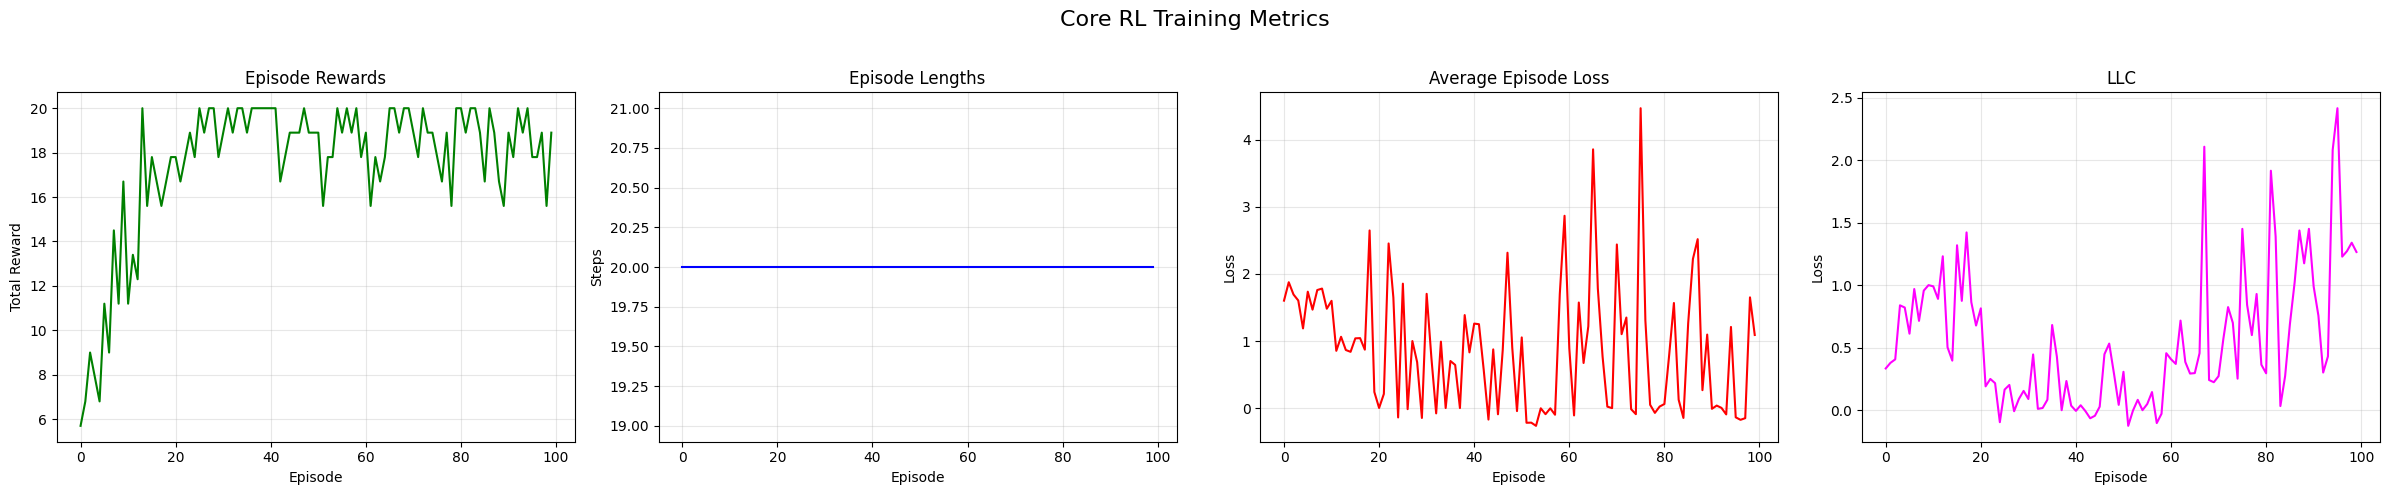

In [6]:
# Plot original training progress
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
fig.suptitle('Core RL Training Metrics', fontsize=16)

# Episode rewards
axes[0].plot(training_history['episode_rewards'], color='green')
axes[0].set_title('Episode Rewards')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total Reward')
axes[0].grid(True, alpha=0.3)

# Episode lengths
axes[1].plot(training_history['episode_lengths'], color='blue')
axes[1].set_title('Episode Lengths')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Steps')
axes[1].grid(True, alpha=0.3)

# Training losses
axes[2].plot(training_history['losses'], color='red')
axes[2].set_title('Average Episode Loss')
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Loss')
axes[2].grid(True, alpha=0.3)
       
llc_means = [h['overall_llc']['llc_mean'] for h in training_history['llc_history']]
llc_stds = [h['overall_llc']['llc_std'] for h in training_history['llc_history']]
# Training losses
axes[3].plot(llc_means, color='magenta')
axes[3].set_title('LLC')
axes[3].set_xlabel('Episode')
axes[3].set_ylabel('Loss')
axes[3].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Step 5: Visualize LLC and Refined LLC Results

Next, we add the new visualizations for the collected LLC data. This includes the evolution of the overall LLC and a more detailed, layer-by-layer breakdown of the refined LLC.

--- Overall LLC Analysis ---


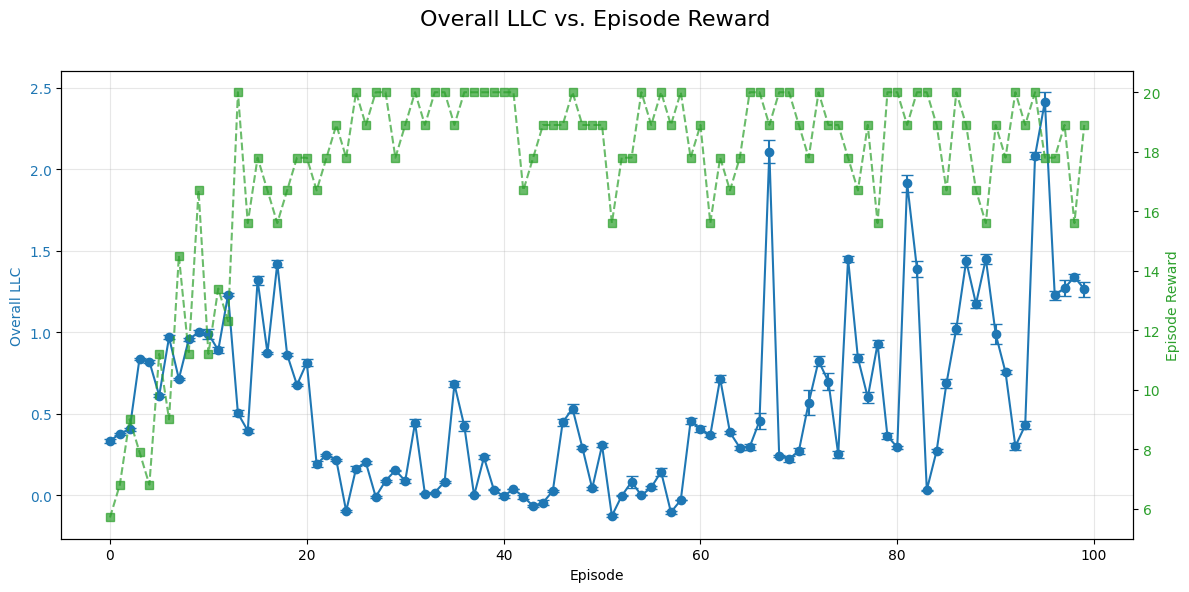


--- Layer-wise LLC Analysis ---


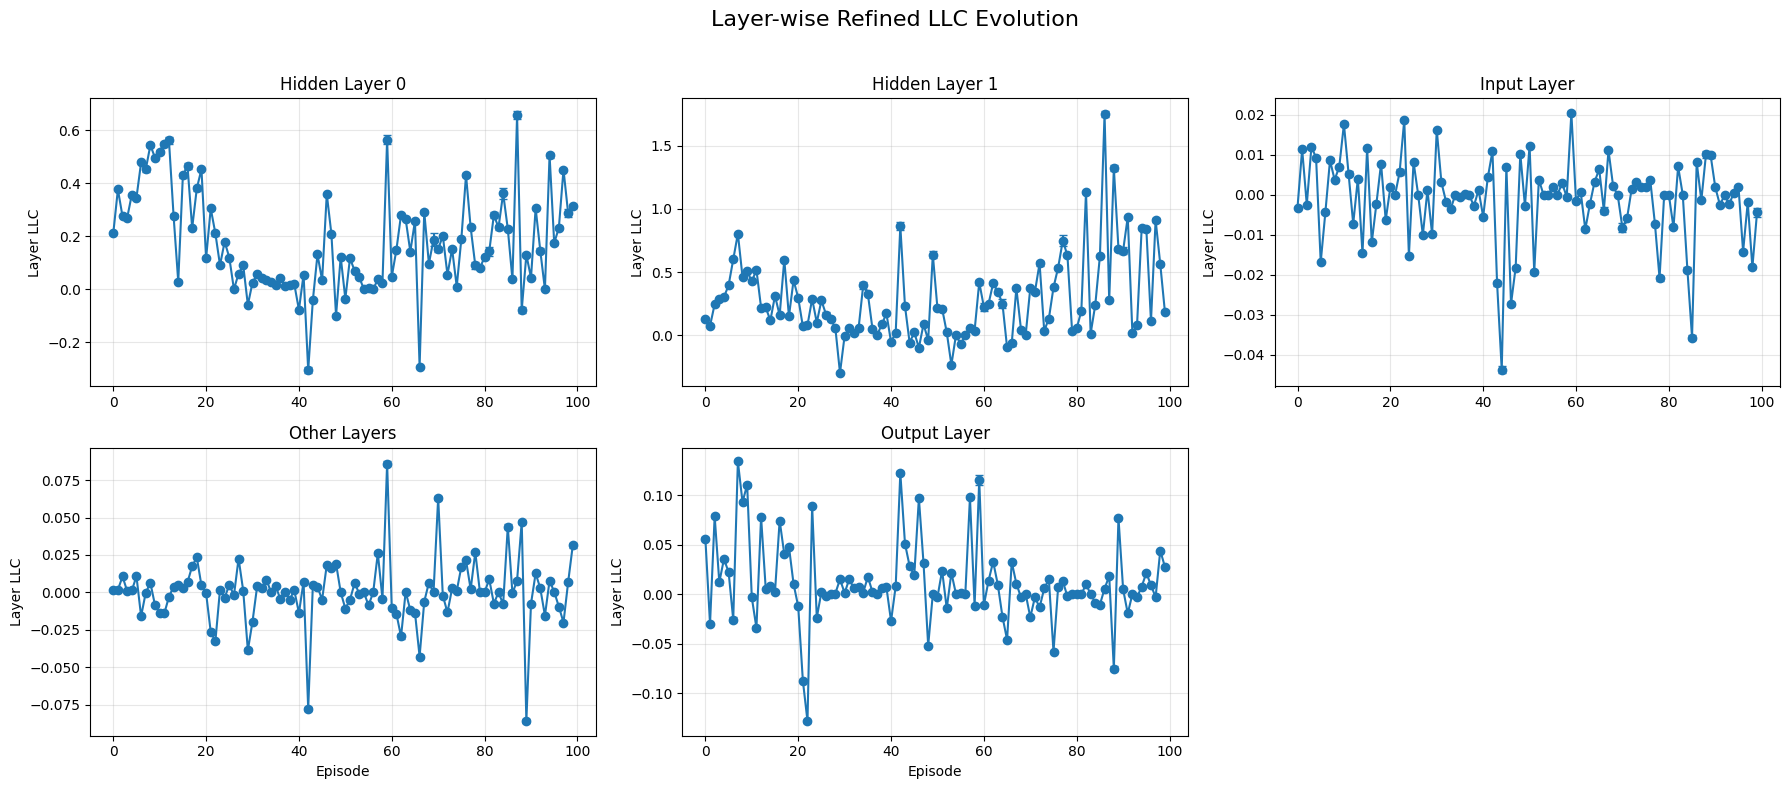

In [7]:
class EnhancedLLCVisualizer:
    """Visualization toolkit for overall and layer-wise LLC analysis."""
    def __init__(self, history: Dict):
        self.history = history
        self.llc_history = history.get('llc_history', [])

    def plot_overall_llc_evolution(self):
        if not self.llc_history:
            print("No LLC history to plot.")
            return
        
        episodes = [h['episode'] for h in self.llc_history]
        llc_means = [h['overall_llc']['llc_mean'] for h in self.llc_history]
        llc_stds = [h['overall_llc']['llc_std'] for h in self.llc_history]
        rewards = [h['reward'] for h in self.llc_history]

        fig, ax1 = plt.subplots(figsize=(12, 6))
        fig.suptitle('Overall LLC vs. Episode Reward', fontsize=16)

        # Plot LLC
        color = 'tab:blue'
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Overall LLC', color=color)
        ax1.errorbar(episodes, llc_means, yerr=llc_stds, fmt='-o', capsize=4, label='Overall LLC', color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)

        # Plot Rewards on a secondary y-axis
        ax2 = ax1.twinx()
        color = 'tab:green'
        ax2.set_ylabel('Episode Reward', color=color)
        ax2.plot(episodes, rewards, 's--', label='Reward', color=color, alpha=0.7)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_layer_wise_evolution(self):
        if not self.llc_history or 'layer_wise_llc' not in self.llc_history[0]:
            print("No layer-wise LLC history to plot.")
            return

        episodes = [h['episode'] for h in self.llc_history]
        layer_names = sorted(self.llc_history[0]['layer_wise_llc'].keys())
        
        if not layer_names:
            print("No layers with LLC data found.")
            return

        n_layers = len(layer_names)
        n_cols = min(3, n_layers)
        n_rows = (n_layers + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4), squeeze=False)
        axes = axes.flatten()
        fig.suptitle('Layer-wise Refined LLC Evolution', fontsize=16)

        last_plot_row = (n_layers - 1) // n_cols
        for i, layer_name in enumerate(layer_names):
            ax = axes[i]
            llc_means = [h['layer_wise_llc'][layer_name]['llc_mean'] for h in self.llc_history if layer_name in h['layer_wise_llc']]
            llc_stds = [h['layer_wise_llc'][layer_name]['llc_std'] for h in self.llc_history if layer_name in h['layer_wise_llc']]
            
            ax.errorbar(episodes, llc_means, yerr=llc_stds, fmt='-o', capsize=3)
            ax.set_title(layer_name.replace('_', ' ').title())
            ax.set_ylabel('Layer LLC')
            ax.grid(True, alpha=0.3)

            # Correctly set x-label only for plots on the bottom-most row
            if i // n_cols == last_plot_row:
                ax.set_xlabel('Episode')

        # Hide any unused subplots
        for i in range(n_layers, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# Instantiate and use the visualizer
llc_visualizer = EnhancedLLCVisualizer(training_history)

print("--- Overall LLC Analysis ---")
llc_visualizer.plot_overall_llc_evolution()

print("\n--- Layer-wise LLC Analysis ---")
llc_visualizer.plot_layer_wise_evolution()

### Step 6: Analysis Summary

Finally, a text-based summary provides a high-level overview of the LLC results from the final training episode. This can help identify which parts of the model were most 'plastic' or complex during learning.

In [8]:
def print_llc_summary(training_history):
    llc_history = training_history.get('llc_history', [])
    if not llc_history:
        print("No LLC data available for summary.")
        return

    final_llc_data = llc_history[-1]
    print("="*60)
    print(f"LLC Analysis Summary for Final Episode ({final_llc_data['episode']})")
    print("="*60)
    
    # Overall LLC
    overall_llc = final_llc_data['overall_llc']
    print(f"\nOverall Model LLC: {overall_llc['llc_mean']:.4f} ± {overall_llc['llc_std']:.4f}")
    
    # Layer-wise LLC
    if 'layer_wise_llc' in final_llc_data:
        print("\nLayer-wise LLC (Refined):")
        layer_data = final_llc_data['layer_wise_llc']
        
        # Sort by absolute LLC value to see most influential layers
        sorted_layers = sorted(layer_data.items(), key=lambda item: abs(item[1]['llc_mean']), reverse=True)
        
        for layer_name, llc_vals in sorted_layers:
            print(f"  - {layer_name:<20}: {llc_vals['llc_mean']:.4f} ± {llc_vals['llc_std']:.4f}")
            
    print("\n" + "="*60)
    print("Summary Interpretation:")
    print("- Higher LLC values suggest a more complex, 'degenerate' region of the loss landscape for that component.")
    print("- Layers with higher LLC might be more sensitive to parameter changes or have more redundant parameters.")

print_llc_summary(training_history)

LLC Analysis Summary for Final Episode (99)

Overall Model LLC: 1.2652 ± 0.0456

Layer-wise LLC (Refined):
  - hidden_layer_0      : 0.3145 ± 0.0066
  - hidden_layer_1      : 0.1851 ± 0.0133
  - other_layers        : 0.0314 ± 0.0019
  - output_layer        : 0.0277 ± 0.0009
  - input_layer         : -0.0044 ± 0.0011

Summary Interpretation:
- Higher LLC values suggest a more complex, 'degenerate' region of the loss landscape for that component.
- Layers with higher LLC might be more sensitive to parameter changes or have more redundant parameters.


In [9]:
# Create output directory
os.makedirs('trained_models', exist_ok=True)

# Convert numpy arrays to Python lists to avoid pickle issues
def convert_numpy_to_list(obj):
    """Recursively convert numpy arrays to lists"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy_to_list(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_list(item) for item in obj]
    else:
        return obj

# Save model checkpoint (weights only)
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size': 1000,
        'd_model': 128,
        'nhead': 4,
        'num_layers': 2,
        'dim_feedforward': 512,
        'dropout': 0.1
    },
    'final_episode': rl_config.num_episodes,
    'device': str(device)
}

model_path = 'trained_models/transformer_rl_model.pt'
torch.save(checkpoint, model_path)
print(f"Model saved to {model_path}")

# Save training history separately as JSON
training_history_converted = convert_numpy_to_list(training_history)
with open('trained_models/training_history.json', 'w') as f:
    json.dump(training_history_converted, f)
print("Training history saved")

# Save reasoning graphs separately
with open('trained_models/reasoning_graphs.pkl', 'wb') as f:
    pickle.dump(training_history['reasoning_graphs'], f)
print("Reasoning graphs saved")

Model saved to trained_models/transformer_rl_model.pt
Training history saved
Reasoning graphs saved


In [10]:
# Load the trained model with weights_only=True (default in PyTorch 2.6+)
try:
    # Try loading with default settings first
    checkpoint = torch.load('trained_models/transformer_rl_model.pt', map_location=device)
except Exception as e:
    print(f"Default loading failed: {e}")
    print("Loading with weights_only=False...")
    # Fallback to weights_only=False if needed
    checkpoint = torch.load('trained_models/transformer_rl_model.pt', 
                           map_location=device, weights_only=False)

# Recreate model
loaded_model = SimpleTransformer(**checkpoint['model_config'])
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.to(device)
loaded_model.eval()

print("Model loaded successfully")

# Load training history
with open('trained_models/training_history.json', 'r') as f:
    loaded_training_history = json.load(f)
print("Training history loaded")

# Load reasoning graphs
with open('trained_models/reasoning_graphs.pkl', 'rb') as f:
    reasoning_graphs = pickle.load(f)
print(f"Loaded {len(reasoning_graphs)} reasoning trajectories")

Model loaded successfully
Training history loaded
Loaded 100 reasoning trajectories


In [15]:
def analyze_reasoning_graph(trajectory, num_clusters=50):
    """
    Analyze the topology of a reasoning trajectory.
    Based on the Topology of Reasoning methodology.
    """
    # Convert trajectory to numpy array
    trajectory_array = np.array(trajectory)
    
    # Cluster reasoning steps
    kmeans = KMeans(n_clusters=min(num_clusters, len(trajectory)), random_state=42)
    cluster_labels = kmeans.fit_predict(trajectory_array)
    
    # Calculate distances between consecutive steps
    distances = []
    for i in range(len(trajectory_array) - 1):
        dist = np.linalg.norm(trajectory_array[i] - trajectory_array[i+1])
        distances.append(dist)
    
    # Analyze graph properties
    results = analyze_graph_properties(cluster_labels, distances)
    
    return results, cluster_labels, distances

def analyze_graph_properties(path, distances):
    """
    Analyze graph properties including loops and small-world characteristics.
    Adapted from the analyze_graph_v2 function.
    """
    # Convert to list of integers
    path = [int(node) for node in path]
    
    # Loop detection
    seen = {}
    has_loop = False
    loop_count = 0
    
    for idx, node in enumerate(path):
        if node in seen and idx - seen[node] > 1:
            has_loop = True
            # Count loop occurrences
            loop_count += 1
        seen[node] = idx
    
    # Build directed graph
    G = nx.DiGraph()
    for i in range(len(path) - 1):
        if path[i] != path[i+1]:  # Skip self-loops
            G.add_edge(path[i], path[i+1], weight=distances[i])
    
    # Calculate graph metrics
    if len(G) > 0:
        # Convert to undirected for some metrics
        G_undirected = G.to_undirected()
        
        # Clustering coefficient
        avg_clustering = nx.average_clustering(G_undirected)
        
        # Average shortest path length (if connected)
        if nx.is_connected(G_undirected):
            avg_path_length = nx.average_shortest_path_length(G_undirected)
            diameter = nx.diameter(G_undirected)
        else:
            # Calculate for largest connected component
            largest_cc = max(nx.connected_components(G_undirected), key=len)
            G_cc = G_undirected.subgraph(largest_cc)
            avg_path_length = nx.average_shortest_path_length(G_cc)
            diameter = nx.diameter(G_cc)
        
        # Small-world analysis
        N = len(G)
        if N > 2:
            K = np.mean([G.degree(n) for n in G.nodes()])
            # Random graph expectations
            C_rand = K / (N - 1) if N > 1 else 0
            L_rand = np.log(N) / np.log(K) if K > 1 else 1
            
            # Small-world metrics
            clustering_norm = avg_clustering / C_rand if C_rand > 0 else 0
            path_length_norm = avg_path_length / L_rand if L_rand > 0 else 1
            
            # Small-world index (should be > 1 for small-world networks)
            small_world_index = clustering_norm / path_length_norm if path_length_norm > 0 else 0
        else:
            clustering_norm = 0
            path_length_norm = 1
            small_world_index = 0
    else:
        avg_clustering = 0
        avg_path_length = 0
        diameter = 0
        clustering_norm = 0
        path_length_norm = 1
        small_world_index = 0
    
    # Average hop length
    avg_hop_length = np.mean(distances) if distances else 0
    hop_length_norm = avg_hop_length / np.mean(distances) if distances else 1
    
    return {
        'has_loop': has_loop,
        'loop_count': loop_count,
        'diameter': diameter,
        'avg_clustering': avg_clustering,
        'avg_path_length': avg_path_length,
        'clustering_norm': clustering_norm,
        'path_length_norm': path_length_norm,
        'avg_hop_length': avg_hop_length,
        'hop_length_norm': hop_length_norm,
        'small_world_index': small_world_index,
        'num_nodes': len(G),
        'num_edges': len(G.edges())
    }

def extract_reasoning_from_checkpoint(model_path, environment, num_episodes=5):
    """
    Extract reasoning graphs from a checkpoint model by running it in the environment.
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Create and load model
    model = SimpleTransformer(**checkpoint['model_config'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    reasoning_trajectories = []
    
    # Run model in environment to collect reasoning trajectories
    for _ in range(num_episodes):
        state = environment.reset().to(device)
        trajectory = []
        done = False
        
        while not done:
            with torch.no_grad():
                # Extract reasoning step
                hidden = model.extract_reasoning_steps(state)
                trajectory.append(hidden.mean(dim=(0, 1)).cpu().numpy())
                
                # Get action
                logits = model(state)
                action = torch.argmax(logits[0, -1]).unsqueeze(0)
                
                # Environment step
                next_state, _, done = environment.step(action)
                state = next_state.to(device)
        
        reasoning_trajectories.append(trajectory)
    
    return reasoning_trajectories

def analyze_checkpoints(checkpoint_dir='trained_models', episodes_to_analyze=None):
    """
    Analyze reasoning graphs from all checkpoint models.
    """
    import glob
    
    # Find all checkpoint files
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'transformer_rl_model_*.pt'))
    
    # Filter for specific episodes if provided
    if episodes_to_analyze:
        checkpoint_files = [f for f in checkpoint_files 
                          if any(str(ep) in f for ep in episodes_to_analyze)]
    
    # Sort by episode number
    def get_episode_num(filename):
        try:
            return int(filename.split('_')[-1].split('.')[0])
        except:
            return 0
    
    checkpoint_files.sort(key=get_episode_num)
    
    checkpoint_results = {}
    
    for checkpoint_file in checkpoint_files:
        episode_num = get_episode_num(checkpoint_file)
        print(f"\nAnalyzing checkpoint at episode {episode_num}...")
        
        # Create new environment for testing
        test_env = SimpleRLEnvironment(vocab_size=1000, seq_length=32)
        
        # Extract reasoning trajectories
        trajectories = extract_reasoning_from_checkpoint(checkpoint_file, test_env, num_episodes=10)
        
        # Analyze trajectories
        trajectory_results = []
        for traj in trajectories:
            if len(traj) > 1:
                results, _, _ = analyze_reasoning_graph(traj)
                trajectory_results.append(results)
        
        checkpoint_results[episode_num] = {
            'trajectories': trajectories,
            'analysis': pd.DataFrame(trajectory_results)
        }
    
    return checkpoint_results

In [16]:
# Analyze reasoning trajectories from checkpoints
print("\n=== Analyzing Reasoning Graphs from Checkpoints ===")

# Get checkpoint episodes (multiples of 10)
checkpoint_episodes = [i for i in range(10, rl_config.num_episodes + 1, 10)]
checkpoint_results = analyze_checkpoints(episodes_to_analyze=checkpoint_episodes)

# Combine results for evolution analysis
evolution_data = []
for episode, data in checkpoint_results.items():
    analysis_df = data['analysis']
    if len(analysis_df) > 0:
        # Add episode information
        summary = {
            'episode': episode,
            'has_loop_ratio': analysis_df['has_loop'].mean(),
            'avg_loop_count': analysis_df['loop_count'].mean(),
            'avg_diameter': analysis_df['diameter'].mean(),
            'avg_clustering': analysis_df['avg_clustering'].mean(),
            'avg_path_length': analysis_df['avg_path_length'].mean(),
            'avg_small_world_index': analysis_df['small_world_index'].mean(),
            'avg_num_nodes': analysis_df['num_nodes'].mean(),
            'avg_num_edges': analysis_df['num_edges'].mean()
        }
        evolution_data.append(summary)

evolution_df = pd.DataFrame(evolution_data).sort_values('episode')

# Also analyze the final training trajectories for comparison
print("\nAnalyzing final training trajectories...")
all_results = []

for i, trajectory in enumerate(tqdm(reasoning_graphs[-20:], desc="Analyzing final trajectories")):  # Last 20 episodes
    if len(trajectory) > 1:
        results, cluster_labels, distances = analyze_reasoning_graph(trajectory)
        results['episode'] = rl_config.num_episodes + i - 20
        all_results.append(results)

# Convert to DataFrame
final_results_df = pd.DataFrame(all_results)

print(f"\nAnalyzed {len(evolution_df)} checkpoints")
print(f"Analyzed {len(final_results_df)} final trajectories")

# Summary statistics
print("\n=== Checkpoint Evolution Summary ===")
print(f"Initial loop ratio (episode 10): {evolution_df.iloc[0]['has_loop_ratio']:.2%}")
print(f"Final loop ratio (episode {evolution_df.iloc[-1]['episode']}): {evolution_df.iloc[-1]['has_loop_ratio']:.2%}")
print(f"Initial avg diameter: {evolution_df.iloc[0]['avg_diameter']:.2f}")
print(f"Final avg diameter: {evolution_df.iloc[-1]['avg_diameter']:.2f}")
print(f"Initial small-world index: {evolution_df.iloc[0]['avg_small_world_index']:.3f}")
print(f"Final small-world index: {evolution_df.iloc[-1]['avg_small_world_index']:.3f}")


=== Analyzing Reasoning Graphs from Checkpoints ===

Analyzing checkpoint at episode 10...

Analyzing checkpoint at episode 20...

Analyzing checkpoint at episode 30...

Analyzing checkpoint at episode 40...

Analyzing checkpoint at episode 50...

Analyzing checkpoint at episode 60...

Analyzing checkpoint at episode 70...

Analyzing checkpoint at episode 80...

Analyzing checkpoint at episode 90...

Analyzing checkpoint at episode 100...

Analyzing final training trajectories...


Analyzing final trajectories:   0%|          | 0/20 [00:00<?, ?it/s]


Analyzed 10 checkpoints
Analyzed 20 final trajectories

=== Checkpoint Evolution Summary ===
Initial loop ratio (episode 10): 0.00%
Final loop ratio (episode 100.0): 0.00%
Initial avg diameter: 19.00
Final avg diameter: 19.00
Initial small-world index: 0.000
Final small-world index: 0.000


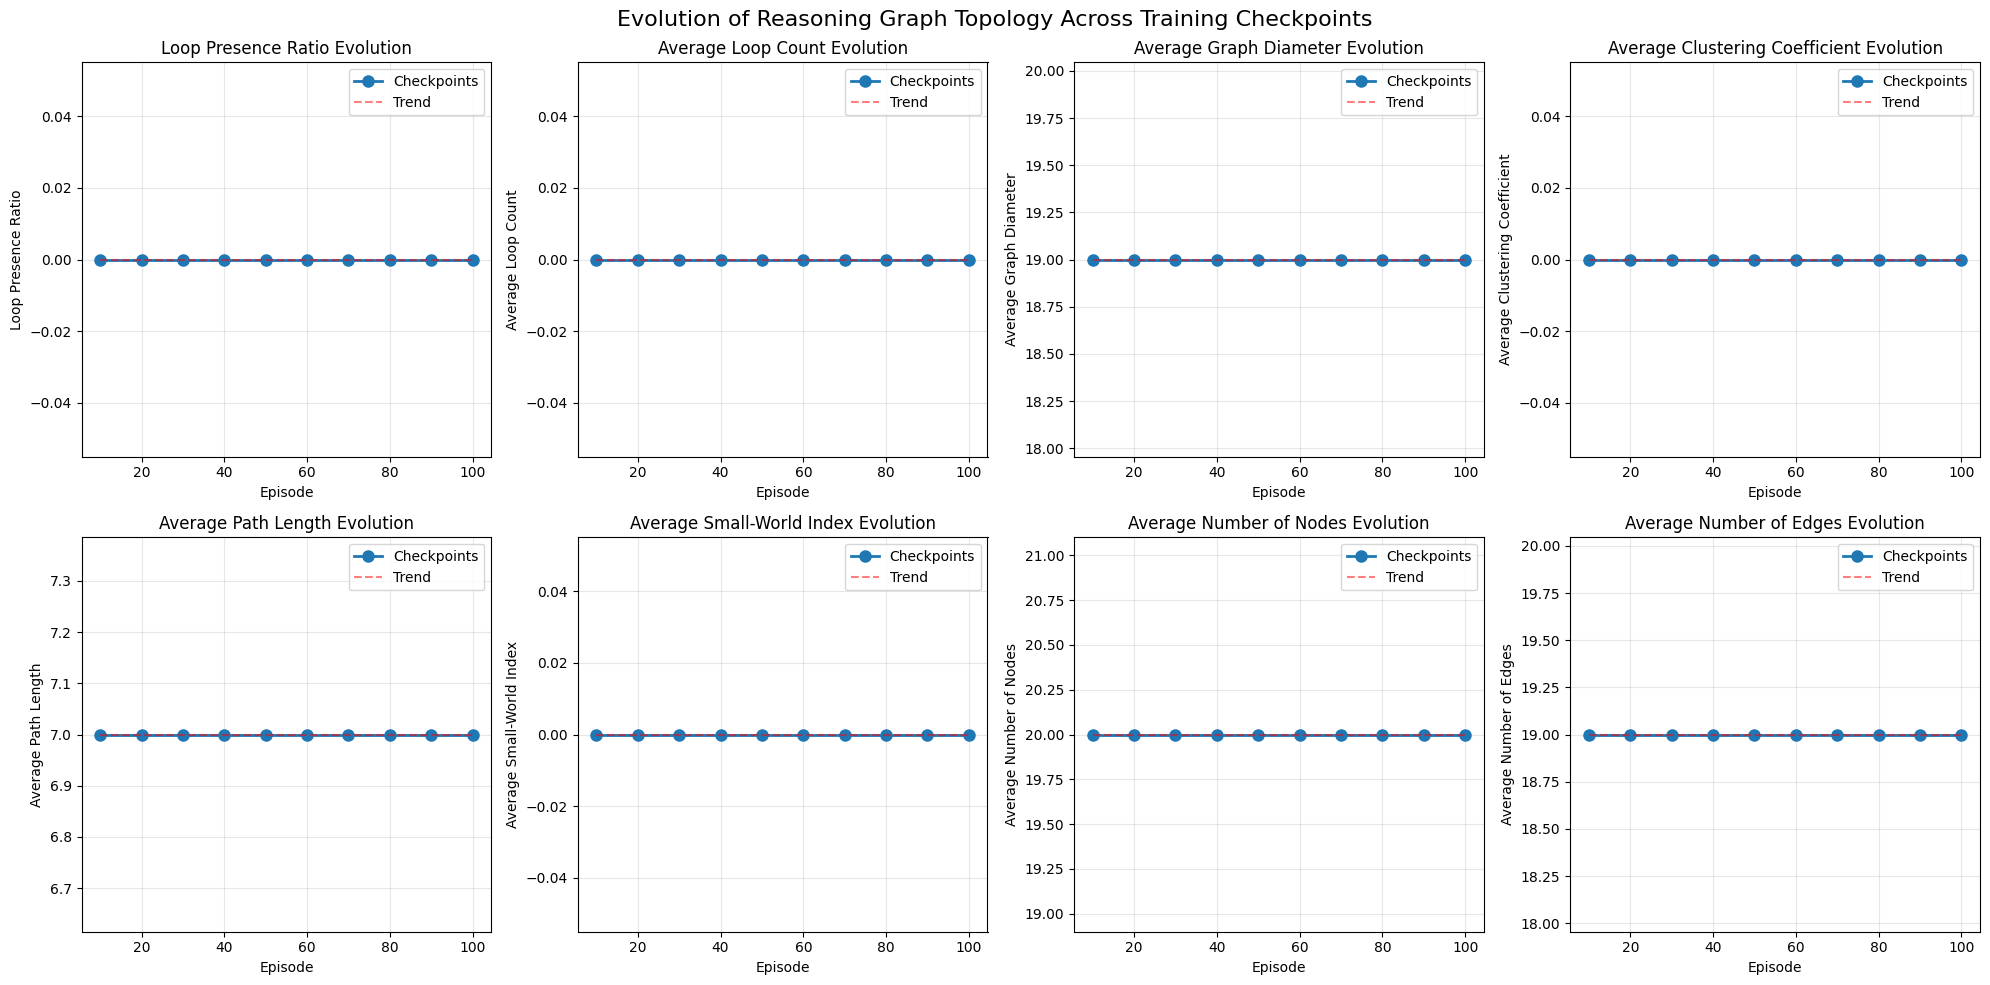

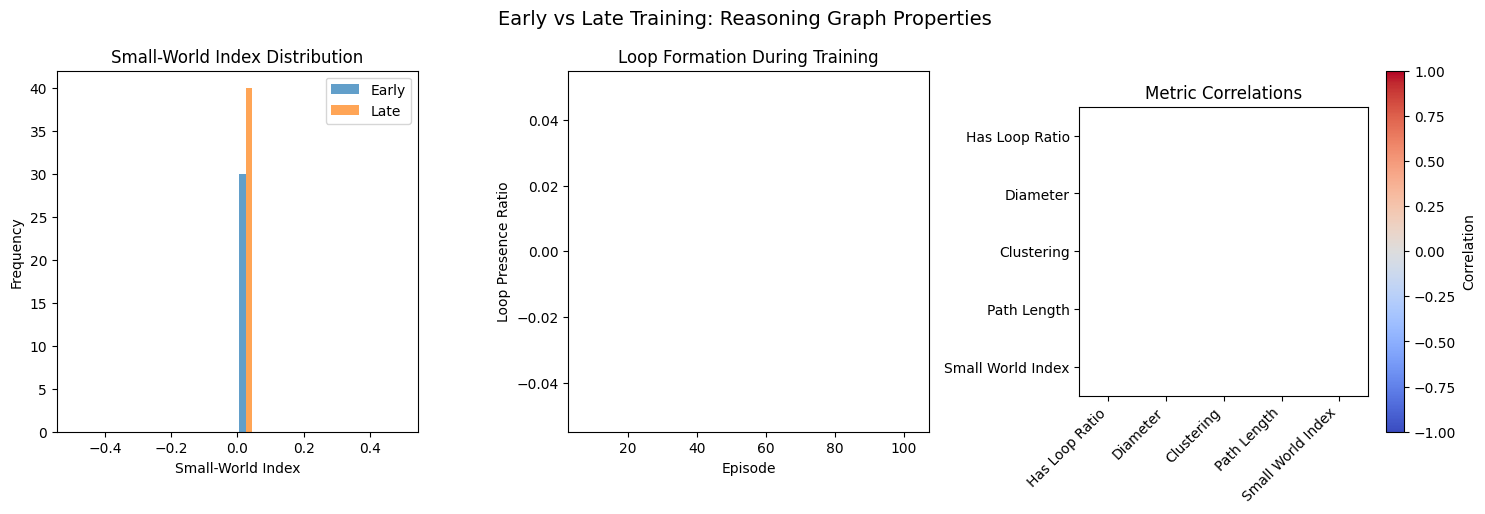

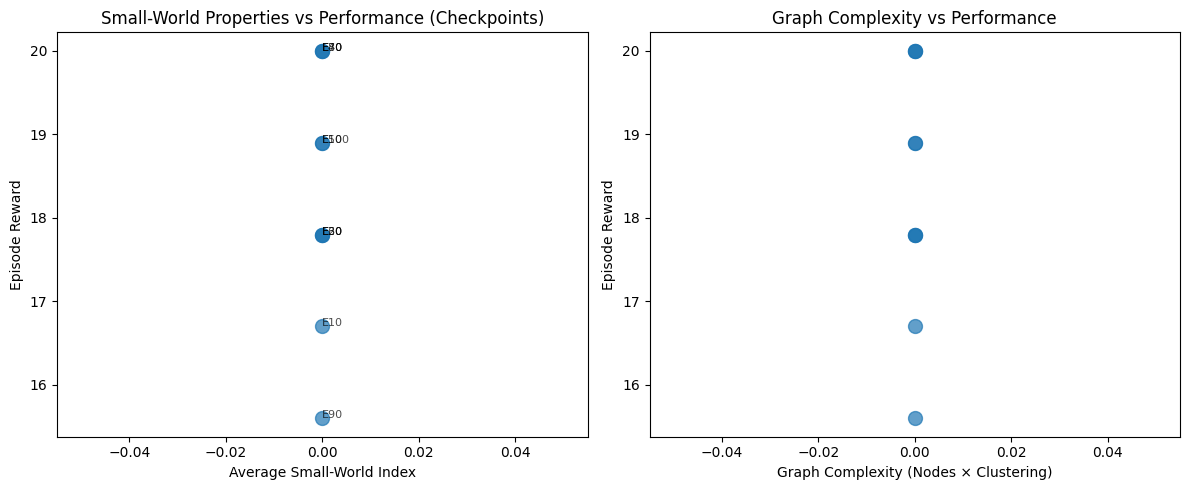

In [17]:
# Visualize how topology metrics evolve during training across checkpoints
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Evolution of Reasoning Graph Topology Across Training Checkpoints', fontsize=16)

# Metrics to plot
metrics = [
    ('has_loop_ratio', 'Loop Presence Ratio'),
    ('avg_loop_count', 'Average Loop Count'),
    ('avg_diameter', 'Average Graph Diameter'),
    ('avg_clustering', 'Average Clustering Coefficient'),
    ('avg_path_length', 'Average Path Length'),
    ('avg_small_world_index', 'Average Small-World Index'),
    ('avg_num_nodes', 'Average Number of Nodes'),
    ('avg_num_edges', 'Average Number of Edges')
]

for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx // 4, idx % 4]
    
    # Plot checkpoint evolution
    ax.plot(evolution_df['episode'], evolution_df[metric], 
            'o-', linewidth=2, markersize=8, label='Checkpoints')
    
    # Add trend line
    if len(evolution_df) > 1:
        z = np.polyfit(evolution_df['episode'], evolution_df[metric], 1)
        p = np.poly1d(z)
        ax.plot(evolution_df['episode'], p(evolution_df['episode']), 
                '--', alpha=0.5, color='red', label='Trend')
    
    ax.set_xlabel('Episode')
    ax.set_ylabel(title)
    ax.set_title(f'{title} Evolution')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Create detailed comparison of early vs late reasoning patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Early vs Late Training: Reasoning Graph Properties', fontsize=14)

# Get early and late checkpoint data
early_episodes = [ep for ep in checkpoint_results.keys() if ep <= 30]
late_episodes = [ep for ep in checkpoint_results.keys() if ep >= max(checkpoint_results.keys()) - 30]

early_data = []
late_data = []

for ep in early_episodes:
    if ep in checkpoint_results:
        early_data.extend(checkpoint_results[ep]['analysis']['small_world_index'].values)

for ep in late_episodes:
    if ep in checkpoint_results:
        late_data.extend(checkpoint_results[ep]['analysis']['small_world_index'].values)

# Small-world index distribution
axes[0].hist([early_data, late_data], bins=20, alpha=0.7, label=['Early', 'Late'])
axes[0].set_xlabel('Small-World Index')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Small-World Index Distribution')
axes[0].legend()

# Loop presence over time
loop_ratios = evolution_df['has_loop_ratio'].values
episodes = evolution_df['episode'].values
axes[1].bar(episodes, loop_ratios, width=5, alpha=0.7)
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Loop Presence Ratio')
axes[1].set_title('Loop Formation During Training')

# Correlation matrix of final checkpoint
if len(evolution_df) > 3:
    corr_metrics = ['has_loop_ratio', 'avg_diameter', 'avg_clustering', 
                    'avg_path_length', 'avg_small_world_index']
    corr_data = evolution_df[corr_metrics].corr()
    
    im = axes[2].imshow(corr_data, cmap='coolwarm', vmin=-1, vmax=1)
    axes[2].set_xticks(range(len(corr_metrics)))
    axes[2].set_yticks(range(len(corr_metrics)))
    axes[2].set_xticklabels([m.replace('avg_', '').replace('_', ' ').title() 
                             for m in corr_metrics], rotation=45, ha='right')
    axes[2].set_yticklabels([m.replace('avg_', '').replace('_', ' ').title() 
                             for m in corr_metrics])
    axes[2].set_title('Metric Correlations')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[2])
    cbar.set_label('Correlation')

plt.tight_layout()
plt.show()

# Performance correlation analysis
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Load rewards for checkpoint episodes
checkpoint_rewards = [loaded_training_history['episode_rewards'][ep-1] 
                     for ep in evolution_df['episode'] 
                     if ep-1 < len(loaded_training_history['episode_rewards'])]

# Small-world index vs performance
ax[0].scatter(evolution_df['avg_small_world_index'][:len(checkpoint_rewards)], 
              checkpoint_rewards, s=100, alpha=0.7)
ax[0].set_xlabel('Average Small-World Index')
ax[0].set_ylabel('Episode Reward')
ax[0].set_title('Small-World Properties vs Performance (Checkpoints)')

# Add episode labels
for i, (x, y, ep) in enumerate(zip(evolution_df['avg_small_world_index'][:len(checkpoint_rewards)], 
                                   checkpoint_rewards, 
                                   evolution_df['episode'][:len(checkpoint_rewards)])):
    ax[0].annotate(f'E{ep}', (x, y), fontsize=8, alpha=0.7)

# Graph complexity vs performance
graph_complexity = evolution_df['avg_num_nodes'] * evolution_df['avg_clustering']
ax[1].scatter(graph_complexity[:len(checkpoint_rewards)], 
              checkpoint_rewards, s=100, alpha=0.7)
ax[1].set_xlabel('Graph Complexity (Nodes × Clustering)')
ax[1].set_ylabel('Episode Reward')
ax[1].set_title('Graph Complexity vs Performance')

plt.tight_layout()
plt.show()

Top 5 trajectories with strongest small-world properties:
   episode  small_world_index  loop_count  avg_clustering  avg_path_length
0        0                0.0           0             0.0              7.0
1        1                0.0           0             0.0              7.0
2        2                0.0           0             0.0              7.0
3        3                0.0           0             0.0              7.0
4        4                0.0           0             0.0              7.0


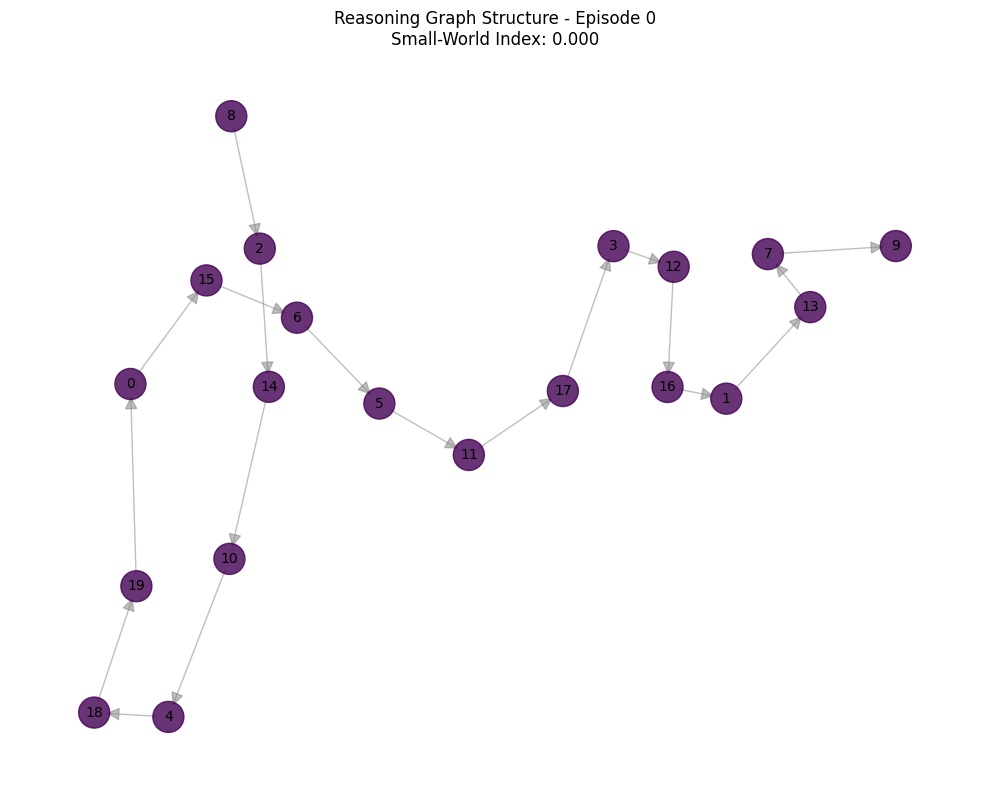


Graph properties:
- Number of unique states: 20
- Total transitions: 19
- Has loops: False
- Loop count: 0


In [18]:
# Find trajectories with strongest small-world properties
best_small_world = results_df.nlargest(5, 'small_world_index')
print("Top 5 trajectories with strongest small-world properties:")
print(best_small_world[['episode', 'small_world_index', 'loop_count', 
                       'avg_clustering', 'avg_path_length']])

# Visualize one of the best trajectories
best_episode = best_small_world.iloc[0]['episode']
best_trajectory = reasoning_graphs[best_episode]

# Cluster the trajectory
trajectory_array = np.array(best_trajectory)
kmeans = KMeans(n_clusters=min(20, len(trajectory_array)), random_state=42)
cluster_labels = kmeans.fit_predict(trajectory_array)

# Create reasoning graph visualization
G = nx.DiGraph()
for i in range(len(cluster_labels) - 1):
    G.add_edge(cluster_labels[i], cluster_labels[i+1])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes
node_colors = [cluster_labels.tolist().count(node) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                      cmap='viridis', node_size=500, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', 
                      arrows=True, arrowsize=20, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title(f'Reasoning Graph Structure - Episode {best_episode}\n'
          f'Small-World Index: {best_small_world.iloc[0]["small_world_index"]:.3f}')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nGraph properties:")
print(f"- Number of unique states: {len(set(cluster_labels))}")
print(f"- Total transitions: {len(cluster_labels) - 1}")
print(f"- Has loops: {best_small_world.iloc[0]['has_loop']}")
print(f"- Loop count: {best_small_world.iloc[0]['loop_count']}")